# トレンドの有無による予測の結果の変化

In [1]:
# Google　Colaboratory で実行する場合はインストールする
if "google.colab" in str(get_ipython()):
    !pip install japanize_matplotlib
    !pip install seaborn

In [2]:
import japanize_matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import os

if os.path.exists("../../stylesheet/k_dm.mplstyle"):
    plt.style.use("../../stylesheet/k_dm.mplstyle")

## サンプルデータを作成

In [4]:
date_list = pd.date_range("2021-01-01", periods=720, freq="D")
value_list = [
    10
    + np.cos(np.pi * i / 28.0) * (i % 3 > 0)
    + np.cos(np.pi * i / 14.0) * (i % 5 > 0)
    + np.cos(np.pi * i / 7.0)
    + (i / 10) ** 1.1 / 20
    for i, di in enumerate(date_list)
]

df = pd.DataFrame(
    {
        "日付": date_list,
        "観測値": value_list,
    }
)

df.head(10)

,日付,観測値
0,2021-01-01,11.000000
1,2021-01-02,12.873581
2,2021-01-03,12.507900
3,2021-01-04,11.017651
4,2021-01-05,11.320187
5,2021-01-06,10.246560
6,2021-01-07,9.350058
7,2021-01-08,9.740880
8,2021-01-09,9.539117
9,2021-01-10,8.987155


<AxesSubplot:xlabel='日付', ylabel='観測値'>

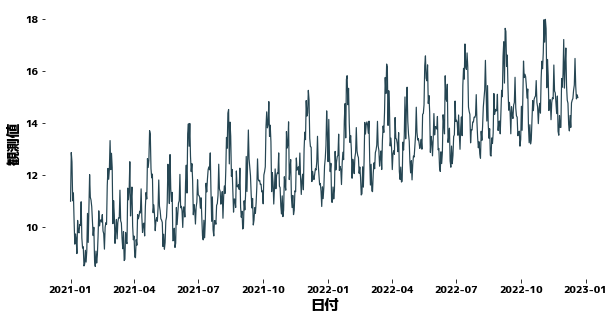

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"], y=df["観測値"])

# XGBoostで時系列データを予測してみる

<AxesSubplot:xlabel='日付', ylabel='観測値'>

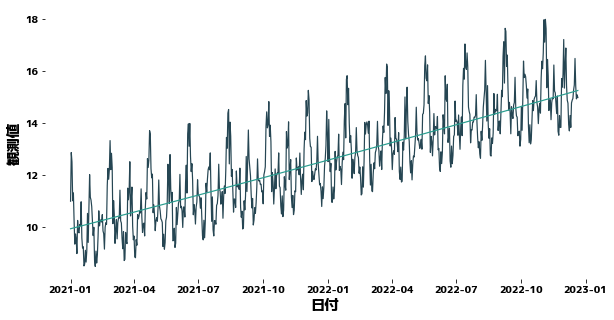

In [6]:
df["曜日"] = df["日付"].dt.weekday
df["年初からの日数%14"] = df["日付"].dt.dayofyear % 14
df["年初からの日数%28"] = df["日付"].dt.dayofyear % 28


def get_trend(timeseries, deg=3, trainN=0):
    """時系列データのトレンドの線を作成する

    Args:
        timeseries(pd.Series) : 時系列データ。
        deg(int) : 多項式の次数
        trainN(int): 多項式の係数を推定するために使用するデータ数

    Returns:
        pd.Series: トレンドに相当する時系列データ。
    """
    if trainN == 0:
        trainN = len(timeseries)

    x = list(range(len(timeseries)))
    y = timeseries.values
    coef = np.polyfit(x[:trainN], y[:trainN], deg)
    trend = np.poly1d(coef)(x)
    return pd.Series(data=trend, index=timeseries.index)


trainN = 500
df["トレンド"] = get_trend(df["観測値"], trainN=trainN, deg=2)

plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"], y=df["観測値"])
sns.lineplot(x=df["日付"], y=df["トレンド"])

In [7]:
X = df[["曜日", "年初からの日数%14", "年初からの日数%28"]]
y = df["観測値"]

trainX, trainy = X[:trainN], y[:trainN]
testX, testy = X[trainN:], y[trainN:]
trend_train, trend_test = df["トレンド"][:trainN], df["トレンド"][trainN:]

## トレンドを考慮せずに予測する

誤差(MSE) = 2.815118389938834


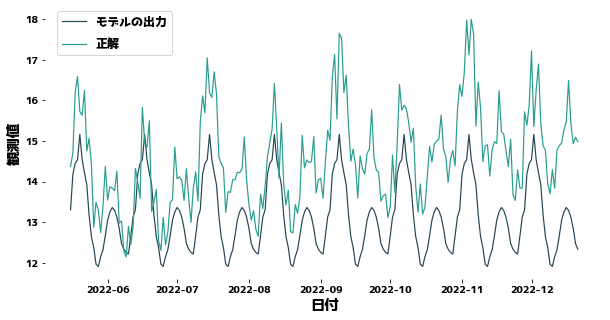

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

regressor = xgb.XGBRegressor(max_depth=5).fit(trainX, trainy)
prediction = regressor.predict(testX)

plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"][trainN:], y=prediction)
sns.lineplot(x=df["日付"][trainN:], y=testy)

plt.legend(["モデルの出力", "正解"], bbox_to_anchor=(0.0, 0.78, 0.28, 0.102))
print(f"誤差(MSE) = {mean_squared_error(testy, prediction)}")

## トレンドを考慮して予測する
先にトレンドに相当する分を観測値から取り除いて、トレンドがない状態の数値を予測します。
その後、トレンドに相当する分を足して最終的な予測値としています。

誤差(MSE) = 0.46014173311011325


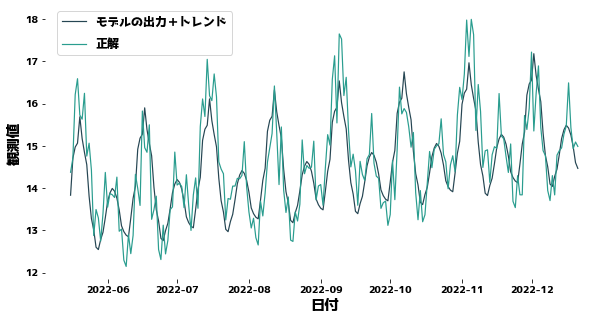

In [9]:
regressor = xgb.XGBRegressor(max_depth=5).fit(trainX, trainy - trend_train)
prediction = regressor.predict(testX)
prediction = [pred_i + trend_i for pred_i, trend_i in zip(prediction, trend_test)]

plt.figure(figsize=(10, 5))
sns.lineplot(x=df["日付"][trainN:], y=prediction)
sns.lineplot(x=df["日付"][trainN:], y=testy)

plt.legend(["モデルの出力＋トレンド", "正解"], bbox_to_anchor=(0.0, 0.78, 0.28, 0.102))
print(f"誤差(MSE) = {mean_squared_error(testy, prediction)}")